# Neuromatch Academy: Week 2, Day 3, Tutorial 3
# Linear Dynamical Systems & The Kalman Filter
__Content creators:__ Caroline Haimerl and Byron Galbraith

__Content reviewers:__ Jesse Livezey, Matt Krause, and Michael Waskom

**Useful reference:**
- Roweis, Ghahramani (1998): A unifying review of linear Gaussian Models
- Bishop (2006): Pattern Recognition and Machine Learning

**Acknowledgement**

This tutorial is in part based on code originally created by Caroline Haimerl for Dr. Cristina Savin's *Probabilistic Time Series* class at the Center for Data Science, New York University

Video available at https://youtu.be/6f_51L3i5aQ


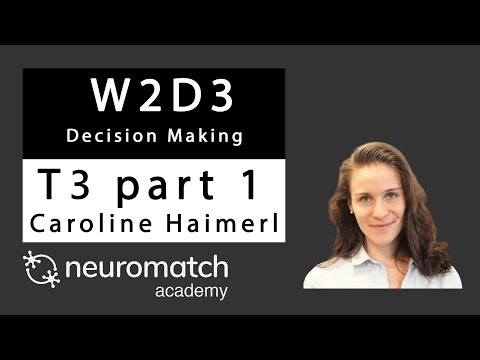

In [ ]:
#@title Video 1: Introduction
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="6f_51L3i5aQ", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

# Summary of Video 1:
linear dynamical systems and the Kalman filter.
- different latent space models
describe the population activity
of neurons, populations of neurons,
both with external stimuli
and internal, so, hidden processes
such as attention, for instance.
- detecting discrete hidden or latent states from data measurements,
which can be well modeled, by, for instance, the hidden Markov model.
- think about what happens if the hidden underlying process cannot be described by a discrete number of states.
- aim is to estimate the true trajectory of the eye, which does not jump between a couple of discrete states,
but moves in a continuous space
So, instead of a hidden Markov model, we can use what is called a linear dynamical system.


---
# Tutorial Objectives

In the previous tutorials we looked at inferring discrete latent states that give rise to our measurements. In this tutorial, we will learn how to infer a latent model when our states are continuous. Particular attention is paid to the Kalman filter and it's mathematical foundation.

In this tutorial, you will:
* Review linear dynamical systems
* Learn about and implement the Kalman filter
* Explore how the Kalman filter can be used to smooth data from an eye-tracking experiment


In [ ]:
# Install PyKalman (https://pykalman.github.io/)
!pip install pykalman --quiet

# Imports
import numpy as np
import matplotlib.pyplot as plt
import pykalman
from scipy import stats

In [ ]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
#@title Data retrieval and loading
import io
import os
import hashlib
import requests

fname = "W2D3_mit_eyetracking_2009.npz"
url = "https://osf.io/jfk8w/download"
expected_md5 = "20c7bc4a6f61f49450997e381cf5e0dd"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

def load_eyetracking_data(data_fname=fname):

  with np.load(data_fname, allow_pickle=True) as dobj:
    data = dict(**dobj)

  images = [plt.imread(io.BytesIO(stim), format='JPG')
            for stim in data['stimuli']]
  subjects = data['subjects']

  return subjects, images

In [ ]:
#@title Helper functions
np.set_printoptions(precision=3)


def plot_kalman(state, observation, estimate=None, label='filter', color='r-',
                title='LDS', axes=None):
    if axes is None:
      fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
      ax1.plot(state[:, 0], state[:, 1], 'g-', label='true latent')
      ax1.plot(observation[:, 0], observation[:, 1], 'k.', label='data')
    else:
      ax1, ax2 = axes

    if estimate is not None:
      ax1.plot(estimate[:, 0], estimate[:, 1], color=color, label=label)
    ax1.set(title=title, xlabel='X position', ylabel='Y position')
    ax1.legend()

    if estimate is None:
      ax2.plot(state[:, 0], observation[:, 0], '.k', label='dim 1')
      ax2.plot(state[:, 1], observation[:, 1], '.', color='grey', label='dim 2')
      ax2.set(title='correlation', xlabel='latent', ylabel='observed')
    else:
      ax2.plot(state[:, 0], estimate[:, 0], '.', color=color,
               label='latent dim 1')
      ax2.plot(state[:, 1], estimate[:, 1], 'x', color=color,
               label='latent dim 2')
      ax2.set(title='correlation',
              xlabel='real latent',
              ylabel='estimated latent')
    ax2.legend()

    return ax1, ax2


def plot_gaze_data(data, img=None, ax=None):
    # overlay gaze on stimulus
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    xlim = None
    ylim = None
    if img is not None:
        ax.imshow(img, aspect='auto')
        ylim = (img.shape[0], 0)
        xlim = (0, img.shape[1])

    ax.scatter(data[:, 0], data[:, 1], c='m', s=100, alpha=0.7)
    ax.set(xlim=xlim, ylim=ylim)

    return ax


def plot_kf_state(kf, data, ax):
    mu_0 = np.ones(kf.n_dim_state)
    mu_0[:data.shape[1]] = data[0]
    kf.initial_state_mean = mu_0

    mu, sigma = kf.smooth(data)
    ax.plot(mu[:, 0], mu[:, 1], 'limegreen', linewidth=3, zorder=1)
    ax.scatter(mu[0, 0], mu[0, 1], c='orange', marker='>', s=200, zorder=2)
    ax.scatter(mu[-1, 0], mu[-1, 1], c='orange', marker='s', s=200, zorder=2)

# Summary of Helper functions:

*plot_kalman*:
plots the states 0 and 1 (true latents) and observations 0 and 1 in order to estimate x and y positions in order to establish correlations between real latents (xaxis) and estimated latents (yaxis). 

*plot_gaze_data*:
overlay the gaze on the stimulus using scatter plot at alpha 0.7

*plot_kf_state*:
plots scatter plots at mu 0 and 1 

---
# Section 1: Linear Dynamical System (LDS)

Video available at https://youtu.be/2SWh639YgEg


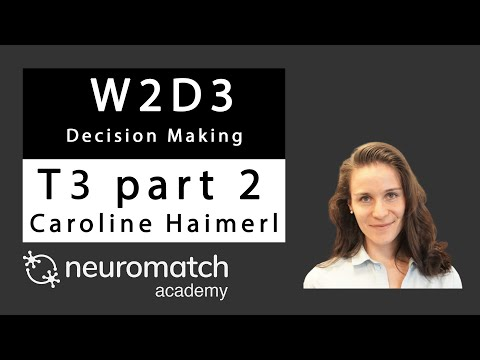

In [2]:
#@title Video 2: Linear Dynamical Systems
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="2SWh639YgEg", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

# Summary of Video 2:

in the framework of the linear dynamical
systems we try to estimate the hidden
continuous process that underlies a
dataset
however we could also think of this as a
problem that the brain needs to solve
when it gets noisy measurements from its
sensory receptors and needs to make
sense of those measurements to form a
decision on how to act so it needs to
extract information about the outside
world which is hidden and that
causes the activation of the sensory
receptors 

so now let's assume we have
some data measurements Y and this could
be a high dimensional but in order to be
able to visualize the data we're going
to basically pick out two dimensions
collected over time; our aim is to find a
later process that underlies our
measured data typically this would have
a lower dimension T 

specifically we assume that the latent
structure can be expressed by continuous
variable s that propagates through time
T with some temporal smoothness which is
expressed by the transition matrix F and
some Gaussian noise which has some
covariance 

this latent variable s
drives the observed or measured data Y
which has its own term either
with its own covariance or with this
series;

we have this latent state that 
drives what we measure in the data
there are two important features of
linear dynamical systems that make them
easy to work with
	- first the latent s and you observed Y
are both normally distributed
and because the transformation been in
time between latent States and from
latent to observed a linear the Joint
Distribution is also normally
distributed and 
	- second justice in the
hidden Markov model we have this
Markovian structure where the latent at
time point t is conditionally
independent of all the previous time
points given its direct predecessor

- implement such linear dynamical system
and sample from it so we're creating our
own simulated data for visualization
purposes we will limit ourselves to
assist them with a two dimensional
latent in a two dimensional observed
variable 
- once you implemented the
sampling should have obtained a latent trajectory and
the data points that reflect this
trajectory but noisily 

Latent state variable: $$s_t = Fs_{t-1}+\zeta_t$$

Measured/observed variable: $$y_t = Hs_{t}+\eta_t$$

The latent state variable has dimension $D$ and the measured variable dimension $N$, dimensionality reduction here means that $D<N$.

Both latent and measured variable have Gaussian noise terms:

\begin{eqnarray}
\zeta_t & \sim & N(0, Q) \\
\eta_t & \sim & N(0, R) \\
s_0 & \sim & N(\mu_0, \Sigma_0)
\end{eqnarray}

As a consequence, $s_t$, $y_t$ and their joint distributions are Gaussian so we can easily compute the marginals and conditionals.

Just as in the HMM, the structure is that of a Markov chain where the state at time point $t$ is conditionally independent of previous states given the state at time point $t-1$.


## Section 1.1: Sampling

The first thing we will investigate is how to generate timecourse samples from a linear dynamical system given its parameters. We will start by defining the following system:

In [ ]:
# task dimensions
n_dim_state = 2
n_dim_obs = 2

# initialize model parameters
params = {
  'F': 0.5 * np.eye(n_dim_state),  # state transition matrix
  'Q': np.eye(n_dim_obs),  # state noise covariance
  'H': np.eye(n_dim_state),  # observation matrix
  'R': 0.1 * np.eye(n_dim_obs),  # observation noise covariance
  'mu_0': np.zeros(n_dim_state),  # initial state mean
  'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
}

**Note**: We used a parameter dictionary `params` above. As the number of parameters we need to provide to our functions increases, it can be beneficial to condense them into a data structure like this to clean up the number of inputs we pass in. The trade-off is that we have to know what is in our data structure to use those values, rather than looking at the function signature directly.

### Exercise 1: Sampling from a linear dynamical system

In this exercise you will implement the dynamics functions of a linear dynamical system to sample both a latent space trajectory (given parameters set above) and noisy measurements.


In [ ]:
def sample_lds(n_timesteps, params, seed=0):
  """ Generate samples from a Linear Dynamical System specified by the provided
  parameters.

  Args:
  n_timesteps (int): the number of time steps to simulate
  params (dict): a dictionary of model paramters: (F, Q, H, R, mu_0, sigma_0)
  seed (int): a random seed to use for reproducibility checks

  Returns:
  ndarray, ndarray: the generated state and observation data
  """
  n_dim_state = params['F'].shape[0]
  n_dim_obs = params['H'].shape[0]

  # set seed
  np.random.seed(seed)

  # precompute random samples from the provided covariance matrices
  # mean defaults to 0
  zi = stats.multivariate_normal(cov=params['Q']).rvs(n_timesteps)
  eta = stats.multivariate_normal(cov=params['R']).rvs(n_timesteps)

  # initialize state and observation arrays
  state = np.zeros((n_timesteps, n_dim_state))
  obs = np.zeros((n_timesteps, n_dim_obs))

  ###################################################################
  ## TODO for students: compute the next state and observation values
  # Fill out function and remove
  raise NotImplementedError("Student excercise: compute the next state and observation values")
  ###################################################################

  # simulate the system
  for t in range(n_timesteps):
    # write the expressions for computing state values given the time step
    if t == 0:
      state[t] = ...
    else:
      state[t] = ...

    # write the expression for computing the observation
    obs[t] = ...

  return state, obs


# Uncomment below to test your function
# state, obs = sample_lds(100, params)
# print('sample at t=3 ', state[3])
# plot_kalman(state, obs, title='sample')

In [ ]:
# to_remove solution
def sample_lds(n_timesteps, params, seed=0):
  """ Generate samples from a Linear Dynamical System specified by the provided
  parameters.

  Args:
  n_timesteps (int): the number of time steps to simulate
  params (dict): a dictionary of model paramters: (F, Q, H, R, mu_0, sigma_0)
  seed (int): a random seed to use for reproducibility checks

  Returns:
  ndarray, ndarray: the generated state and observation data
  """
  n_dim_state = params['F'].shape[0]
  n_dim_obs = params['H'].shape[0]

  # set seed
  np.random.seed(seed)

  # precompute random samples from the provided covariance matrices
  # mean defaults to 0
  zi = stats.multivariate_normal(cov=params['Q']).rvs(n_timesteps)
  eta = stats.multivariate_normal(cov=params['R']).rvs(n_timesteps)

  # initialize state and observation arrays
  state = np.zeros((n_timesteps, n_dim_state))
  obs = np.zeros((n_timesteps, n_dim_obs))

  # simulate the system
  for t in range(n_timesteps):
    # write the expressions for computing state values given the time step
    if t == 0:
      state[t] = stats.multivariate_normal(mean=params['mu_0'],
                                           cov=params['sigma_0']).rvs(1)
    else:
      state[t] = params['F'] @ state[t-1] + zi[t]

    # write the expression for computing the observation
    obs[t] = params['H'] @ state[t] + eta[t]

  return state, obs


state, obs = sample_lds(100, params)
print('sample at t=3 ', state[3])
with plt.xkcd():
  plot_kalman(state, obs, title='sample')

### Interactive Demo: Adjusting System Dynamics
To test your understanding of the parameters of a linear dynamical system, think about what you would expect if you made the following changes:
1. Reduce observation noise $R$
2. Increase respective temporal dynamics $F$

Use the interactive widget below to vary the values of $R$ and $F$.

In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact(R=widgets.FloatLogSlider(0.1, min=-3, max=1),
                  F=widgets.FloatSlider(0.5, min=0.0, max=1.0))
def explore_dynamics(R=0.1, F=0.5):
    params = {
    'F': F * np.eye(n_dim_state),  # state transition matrix
    'Q': np.eye(n_dim_obs),  # state noise covariance
    'H': np.eye(n_dim_state),  # observation matrix
    'R': R * np.eye(n_dim_obs),  # observation noise covariance
    'mu_0': np.zeros(n_dim_state),  # initial state mean,
    'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
    }

    state, obs = sample_lds(100, params)
    plot_kalman(state, obs, title='sample')

---
# Section 2: Kalman Filtering


Video available at https://youtu.be/VboZOV9QMOI


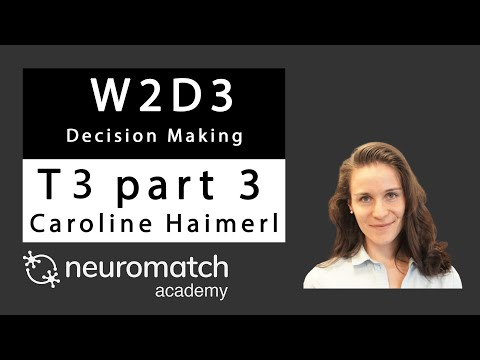

In [3]:
#@title Video 3: Kalman Filtering
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="VboZOV9QMOI", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

# Summary of Video 3:

- infer the latent state distribution from the data using the Kalman filter.
If we are given a data set we typically do not know about the latent state trajectory since it is per definition hidden.
We instead need to infer it directly from the data.
For instance, take a recording from a population of neurons. We do not know
what they are coding for but want to infer it from their activity.
This process is called inference, and has a nice solution formalized by the Kalman filter for the linear dynamical system.
When we do inference we expect that our parameters summarized by theta are simply given, are known.
- The inference can be done in two steps.
	-  First the filtering where we estimate the latent online, so to say, so as theta comes in.
We're working forward in time
basically every time we get a new data point we're estimating the corresponding weight distribution.
	- Smoothing is the second step and it's a little bit less intuitive
because here we estimate the latent given the whole data sequence,
but using the results from the filtering step. And this is also called the backward pass
since we are working from the last sample back to the first.

In the linear dynamical system we can do filtering one time step at a time.
Let's take the example where we have some estimate of our latent distribution at time point t - 1
and we are getting a new data observation y at time point t.
We now want to estimate the corresponding latent distribution at time point t.
Given what we know about the latent at the previous time point and about the data.
We already know that this would be again a Gaussian distribution. So we just need to find the mean and the covariance.
And we will do this in three Gaussian transformations.
	- First we have prediction.
Here we operate exclusively in the latent space, so using the prior.
	- We simply project the latent distribution at the previous time point one time step forward
using the transformation matrix F.
Again, because the initial distribution is Gaussian and because we're simply adding Gaussian noise
we know this distribution will be Gaussian again, and we just need to find the mean and the covariance, which is straightforward. 
The mean
will be F times the mean at the previous time point, and
the same for the covariance. Except that for the covariance
we need to add the noise covariance of the Gaussian noise that is added at time point t.
	- Next we want to compare this prior prediction to the measured data.
So for this we project our estimated latent distribution into the observed space through the observation matrix H.
but instead we stay at the same time point and we move from latent to observed space.
This means we are making a guess about where we think the data should lie given the prior.
Now we can compare
our prediction to the actual measured data Y.
And compute the difference that we have here
between the mean of the of the projected distribution and
Y.

Given this comparison we can derive a correction now back for our initial estimate of the latent distribution.
This correction will change the mean and the covariance by a factor called the Kalman gain.
The Kalman gain compares our certainty about the prior prediction in latent space
to our certainty about our data measurements.
Importantly, the Kalman gain depends inversely on the measurement noise R.
If the measurement noise R is small, we have a large gain and heavily rely on the data.
If R is large,
so we're not very certain about our data and we think we have a lot of noise,
we only make a small correction based on the data. Mostly we're going to rely on the prior in that case.
With this correction, we derive the filter estimate of our latent distribution at time point t.
We can now continue propagating our distribution further along in time, step by step.
This means that our final Kalman filter estimation of the latent distribution at time point t will be used for the next time step.
In different words, the posterior distribution at time point t will be the prior at time point t + 1.

We want to infer the latent state variable $s_t$ given the measured (observed) variable $y_t$.

$$P(s_t|y_1, ..., y_t, y_{t+1}, ..., y_T)\sim N(\hat{\mu_t}, \hat{\Sigma_t})$$

First we obtain estimates of the latent state by running the filtering from $n=0,....N$.

$$s_t^{pred}\sim N(\hat{\mu}_t^{pred},\hat{\Sigma}_t^{pred})$$

Where $\hat{\mu}_t^{pred}$ and $\hat{\Sigma}_t^{pred}$ are derived as follows:

\begin{eqnarray}
\hat{\mu}_1^{pred} & = & F\hat{\mu}_{0} \\
\hat{\mu}_t^{pred} & = & F\hat{\mu}_{t-1}
\end{eqnarray}

*this is the prediction for $s_t$ obtained simply by taking the expected value of $s_{t-1}$ and projecting it forward one step using the transition probability matrix $A$*

\begin{eqnarray}
\hat{\Sigma}_0^{pred} & = & F\hat{\Sigma}_{0}F^T+Q \\
\hat{\Sigma}_t^{pred} & = & F\hat{\Sigma}_{t-1}F^T+Q
\end{eqnarray}

*same for the covariance taking into account the noise covariance $Q$*

update from observation to obtain $\hat{\mu}_t^{filter}$ and $\hat{\Sigma}_t^{filter}$

project to observational space:
$$y_t^{pred}\sim N(H\hat{\mu}_t^{pred}, H\hat{\Sigma}_t^{pred}H^T+R)$$

update prediction by actual data:

\begin{eqnarray}
s_t^{filter} & \sim & N(\hat{\mu}_t^{filter}, \hat{\Sigma}_t^{filter}) \\
\hat{\mu}_t^{filter} & = & \hat{\mu}_t^{pred}+K_t(y_t-H\hat{\mu}_t^{pred}) \\
\hat{\Sigma}_t^{filter} & = & (I-K_tH)\hat{\Sigma}_t^{pred}
\end{eqnarray}

Kalman gain matrix: 
$$K_t=\hat{\Sigma}_t^{pred}H^T(H\hat{\Sigma}_t^{pred}H^T+R)^{-1}$$

*we use the latent-only prediction to project it to the observational space and compute a correction proportional to the error $y_t-HFz_{t-1}$ between prediction and data, coefficient of this correction is the Kalman gain matrix*

*if measurement noise is small and dynamics are fast -> estimation will depend mostly on observed data*

In order to explore the impact of filtering, we will use the following noisy periodic system:

In [ ]:
# task dimensions
n_dim_state = 2
n_dim_obs = 2

# initialize model parameters
params = {
  'F': np.array([[1., 1.], [-(2*np.pi/20.)**2., .9]]),  # state transition matrix
  'Q': np.eye(n_dim_obs),  # state noise covariance
  'H': np.eye(n_dim_state),  # observation matrix
  'R': 1.0 * np.eye(n_dim_obs),  # observation noise covariance
  'mu_0': np.zeros(n_dim_state),  # initial state mean
  'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
}

state, obs = sample_lds(100, params)
plot_kalman(state, obs, title='sample')

## Exercise 2: Implement Kalman filtering
In this exercise you will implement the Kalman filter (forward) process. Your focus will be on writing the expressions for the Kalman gain, filter mean, and filter covariance at each time step (refer to the equations above).

In [ ]:
def kalman_filter(data, params):
  """ Perform Kalman filtering (forward pass) on the data given the provided
  system parameters.

  Args:
    data (ndarray): a sequence of osbervations of shape(n_timesteps, n_dim_obs)
    params (dict): a dictionary of model paramters: (F, Q, H, R, mu_0, sigma_0)

  Returns:
    ndarray, ndarray: the filtered system means and noise covariance values
  """
  # pulled out of the params dict for convenience
  F = params['F']
  Q = params['Q']
  H = params['H']
  R = params['R']

  n_dim_state = F.shape[0]
  n_dim_obs = H.shape[0]
  I = np.eye(n_dim_state)  # identity matrix

  # state tracking arrays
  mu = np.zeros((len(data), n_dim_state))
  sigma = np.zeros((len(data), n_dim_state, n_dim_state))

  # filter the data
  for t, y in enumerate(data):
    if t == 0:
      mu_pred = params['mu_0']
      sigma_pred = params['sigma_0']
    else:
      mu_pred = F @ mu[t-1]
      sigma_pred = F @ sigma[t-1] @ F.T + Q

    ###########################################################################
    ## TODO for students: compute the filtered state mean and covariance values
    # Fill out function and remove
    raise NotImplementedError("Student excercise: compute the filtered state mean and covariance values")
    ###########################################################################
    # write the expression for computing the Kalman gain
    K = ...
    # write the expression for computing the filtered state mean
    mu[t] = ...
    # write the expression for computing the filtered state noise covariance
    sigma[t] = ...

  return mu, sigma


# Uncomment below to test your function
# filtered_state_means, filtered_state_covariances = kalman_filter(obs, params)
# plot_kalman(state, obs, filtered_state_means, title="my kf-filter",
#             color='r', label='my kf-filter')

In [ ]:
# to_remove solution
def kalman_filter(data, params):
  """ Perform Kalman filtering (forward pass) on the data given the provided
  system parameters.

  Args:
    data (ndarray): a sequence of osbervations of shape(n_timesteps, n_dim_obs)
    params (dict): a dictionary of model paramters: (F, Q, H, R, mu_0, sigma_0)

  Returns:
    ndarray, ndarray: the filtered system means and noise covariance values
  """
  # pulled out of the params dict for convenience
  F = params['F']
  Q = params['Q']
  H = params['H']
  R = params['R']

  n_dim_state = F.shape[0]
  n_dim_obs = H.shape[0]
  I = np.eye(n_dim_state)  # identity matrix

  # state tracking arrays
  mu = np.zeros((len(data), n_dim_state))
  sigma = np.zeros((len(data), n_dim_state, n_dim_state))

  # filter the data
  for t, y in enumerate(data):
    if t == 0:
      mu_pred = params['mu_0']
      sigma_pred = params['sigma_0']
    else:
      mu_pred = F @ mu[t-1]
      sigma_pred = F @ sigma[t-1] @ F.T + Q

    # write the expression for computing the Kalman gain
    K = sigma_pred @ H.T @ np.linalg.inv(H @ sigma_pred @ H.T + R)
    # write the expression for computing the filtered state mean
    mu[t] = mu_pred + K @ (y - H @ mu_pred)
    # write the expression for computing the filtered state noise covariance
    sigma[t] = (I - K @ H) @ sigma_pred

  return mu, sigma


filtered_state_means, filtered_state_covariances = kalman_filter(obs, params)
with plt.xkcd():
  plot_kalman(state, obs, filtered_state_means, title="my kf-filter",
              color='r', label='my kf-filter')

---
# Section 3: Fitting Eye Gaze Data

Video available at https://youtu.be/M7OuXmVWHGI


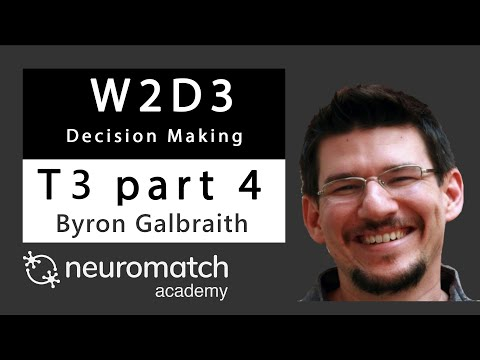

In [4]:
#@title Video 4: Fitting Eye Gaze Data
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="M7OuXmVWHGI", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

# Summary of Video 4:

- look at an application of Kalman filtering and in particular how we can use it to smooth
potentially noisy eye-tracking gaze data
from a visual saliency task.
- visual saliency
is the idea of what in an image draws our attention?
What draws our gaze? And so subjects were asked to stare at a screen,
fixate at the center of a screen and an image 
appeared and they were given a few seconds to just sort of freely gaze around the image as whatever drew their attention.
And then their gaze was tracked over time using an eye tracking device 
And so we have a series of samples that were taken at regular intervals as the subject gazed around the image.
- how can we take this data and find a smooth estimate to remove
potential sources of noise. So in an eye tracking experiments noise can come from just changes an ambient light,
the subjects head moved too far away from the initial calibration point, they blinked, things like that.
- The dimensionality of our observations, which in this case is also 2, the actual observed x and y coordinates of the
pixels. And then we tell it what parameters we want it to fit using the expectation maximization algorithm.
And so in this case, it's the transition matrices F
the transition covariance Q, the observation matrices H, and the observation covariance R.
And then we're gonna give a small amount of noise as our initial
covariance estimate. 
expectation-maximization algorithm run on our data set will try to fit those parameters that we specified.
and one thing that's worth noting is that the model fit is basically the identity matrix.
the way we can interpret that is that these are largely
independent. That the current coordinate has very little dependence on of X for instance on Y and vice versa
both on the state transition as well as than the observed
representation. The noise
covariances though are pretty large for this subject's data.
And again these values are in pixels. So that's why they might look large especially
in this case. So now that we have this we can go back and apply our
filtering or Kalman smoothing to the data to see if we can get a better true estimate of that
continuous gaze sweep. 
- apply technique to images from the same subject
what if we took their fit model to point it to other Subjects?


Tracking eye gaze is used in both experimental and user interface applications. Getting an accurate estimation of where someone is looking on a screen in pixel coordinates can be challenging, however, due to the various sources of noise inherent in obtaining these measurements. A main source of noise is the general accuracy of the eye tracker device itself and how well it maintains calibration over time. Changes in ambient light or subject position can further reduce accuracy of the sensor. Eye blinks introduce a different form of noise as interruptions in the data stream which also need to be addressed.

Fortunately we have a candidate solution for handling noisy eye gaze data in the Kalman filter we just learned about. Let's look at how we can apply these methods to a small subset of data taken from the [MIT Eyetracking Database](http://people.csail.mit.edu/tjudd/WherePeopleLook/index.html) [[Judd et al. 2009](http://people.csail.mit.edu/tjudd/WherePeopleLook/Docs/wherepeoplelook.pdf)]. This data was collected as part of an effort to model [visual saliency](http://www.scholarpedia.org/article/Visual_salience) -- given an image, can we predict where a person is most likely going to look.

In [ ]:
# load eyetracking data
subjects, images = load_eyetracking_data()

## Interactive Demo: Tracking Eye Gaze

We have three stimulus images and five different subjects' gaze data. Each subject fixated in the center of the screen before the image appeared, then had a few seconds to freely look around. You can use the widget below to see how different subjects visually scanned the presented image. A subject ID of -1 will show the stimulus images without any overlayed gaze trace. 

Note that the images are rescaled below for display purposes, they were in their original aspect ratio during the task itself.

In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact(subject_id=widgets.IntSlider(-1, min=-1, max=4),
                  image_id=widgets.IntSlider(0, min=0, max=2))
def plot_subject_trace(subject_id=-1, image_id=0):
  if subject_id == -1:
    subject = np.zeros((3, 0, 2))
  else:
    subject = subjects[subject_id]
  data = subject[image_id]
  img = images[image_id]

  fig, ax = plt.subplots()
  ax.imshow(img, aspect='auto')
  ax.scatter(data[:, 0], data[:, 1], c='m', s=100, alpha=0.7)
  ax.set(xlim=(0, img.shape[1]), ylim=(img.shape[0], 0))

## Section 3.1: Fitting data with `pykalman`

Now that we have data, we'd like to use Kalman filtering to give us a better estimate of the true gaze. Up until this point we've known the parameters of our LDS, but here we need to estimate them from data directly. We will use the `pykalman` package to handle this estimation using the EM algorithm.

Before exploring fitting models with `pykalman` it's worth pointing out some naming conventions used by the library:

$$
\begin{align}
F &: \texttt{transition_matrices} & 
Q &: \texttt{transition_covariance}\\
H &:\texttt{observation_matrices} &
R &:\texttt{observation_covariance}\\
\mu_0 &: \texttt{initial_state_mean} & \Sigma_0 &: \texttt{initial_state_covariance}
\end{align}
$$

The first thing we need to do is provide a guess at the dimensionality of the latent state. Let's start by assuming the dynamics line-up directly with the observation data (pixel x,y-coordinates), and so we have a state dimension of 2.

We also need to decide which parameters we want the EM algorithm to fit. In this case, we will let the EM algorithm discover the dynamics parameters i.e. the $F$, $Q$, $H$, and $R$ matrices.

We set up our `pykalman` `KalmanFilter` object with these settings using the code below.

In [ ]:
# set up our KalmanFilter object and tell it which parameters we want to
# estimate
np.random.seed(1)

n_dim_obs = 2
n_dim_state = 2

kf = pykalman.KalmanFilter(
  n_dim_state=n_dim_state,
  n_dim_obs=n_dim_obs,
  em_vars=['transition_matrices', 'transition_covariance',
           'observation_matrices', 'observation_covariance']
)

Because we know from the reported experimental design that subjects fixated in the center of the screen right before the image appears, we can set the initial starting state estimate $\mu_0$ as being the center pixel of the stimulus image (the first data point in this sample dataset) with a correspondingly low initial noise covariance $\Sigma_0$. Once we have everything set, it's time to fit some data.

In [ ]:
# Choose a subject and stimulus image
subject_id = 1
image_id = 2
data = subjects[subject_id][image_id]

# Provide the initial states
kf.initial_state_mean = data[0]
kf.initial_state_covariance = 0.1*np.eye(n_dim_state)

# Estimate the parameters from data using the EM algorithm
kf.em(data)

print(f'F =\n{kf.transition_matrices}')
print(f'Q =\n{kf.transition_covariance}')
print(f'H =\n{kf.observation_matrices}')
print(f'R =\n{kf.observation_covariance}')

We see that the EM algorithm has found fits for the various dynamics parameters. One thing you will note is that both the state and observation matrices are close to the identity matrix, which means the x- and y-coordinate dynamics are independent of each other and primarily impacted by the noise covariances.

We can now use this model to smooth the observed data from the subject. In addition to the source image, we can also see how this model will work with the gaze recorded by the same subject on the other images as well, or even with different subjects.

Below are the three stimulus images overlayed with recorded gaze in magenta and smoothed state from the filter in green, with gaze begin (orange triangle) and gaze end (orange square) markers. 

In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact(subject_id=widgets.IntSlider(1, min=0, max=4))
def plot_smoothed_traces(subject_id=0):
  subject = subjects[subject_id]
  fig, axes = plt.subplots(ncols=3, figsize=(18, 4))
  for data, img, ax in zip(subject, images, axes):
    ax = plot_gaze_data(data, img=img, ax=ax)
    plot_kf_state(kf, data, ax)

Why do you think one trace from one subject was sufficient to provide a decent fit across all subjects? If you were to go back and change the subject_id and/or image_id for when we fit the data using EM, do you think the fits would be different?

Finally, recall that the original task was to use this data to help develop models of visual salience. While our Kalman filter is able to provide smooth estimates of observed gaze data, it's not telling us anything about *why* the gaze is going in a certain direction. In fact, if we sample data from our parameters and plot them, we get what amounts to a random walk.

In [ ]:
kf_state, kf_data = kf.sample(len(data))
ax = plot_gaze_data(kf_data, img=images[2])
plot_kf_state(kf, kf_data, ax)

This should not be surprising, as we have given the model no other observed data beyond the pixels at which gaze was detected. We expect there is some other aspect driving the latent state of where to look next other than just the previous fixation location.

In summary, while the Kalman filter is a good option for smoothing the gaze trajectory itself, especially if using a lower-quality eye tracker or in noisy environmental conditions, a linear dynamical system may not be the right way to approach the much more challenging task of modeling visual saliency.


# Bonus

## Review on Gaussian joint, marginal and conditional distributions

Assume

\begin{eqnarray}
z & = & [x^Ty^T]^T \\
z & = & \begin{bmatrix}x \\y\end{bmatrix}\sim N\left(\begin{bmatrix}a \\b\end{bmatrix}, \begin{bmatrix}A & C \\C^T & B\end{bmatrix}\right)
\end{eqnarray}

then the marginal distributions are

\begin{eqnarray}
x & \sim & N(a, A) \\
y & \sim & N(b,B)
\end{eqnarray}

and the conditional distributions are

\begin{eqnarray}
x|y & \sim & N(a+CB^{-1}(y-b), A-CB^{-1}C^T) \\
y|x & \sim & N(b+C^TA^{-1}(x-a), B-C^TA^{-1}C)
\end{eqnarray}

*important take away: given the joint Gaussian distribution we can derive the conditionals*

## Kalman Smoothing

In [ ]:
#@title Video 5: Kalman Smoothing and the EM Algorithm
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="4Ar2mYz1Nms", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Obtain estimates by propagating from $y_T$ back to $y_0$ using results of forward pass ($\hat{\mu}_t^{filter}, \hat{\Sigma}_t^{filter}, P_t=\hat{\Sigma}_{t+1}^{pred}$)

\begin{eqnarray}
s_t & \sim & N(\hat{\mu}_t^{smooth}, \hat{\Sigma}_t^{smooth}) \\
\hat{\mu}_t^{smooth} & = & \hat{\mu}_t^{filter}+J_t(\hat{\mu}_{t+1}^{smooth}-F\hat{\mu}_t^{filter}) \\
\hat{\Sigma}_t^{smooth} & = & \hat{\Sigma}_t^{filter}+J_t(\hat{\Sigma}_{t+1}^{smooth}-P_t)J_t^T \\
J_t & = & \hat{\Sigma}_t^{filter}F^T P_t^{-1}
\end{eqnarray}

This gives us the final estimate for $z_t$.

\begin{eqnarray}
\hat{\mu}_t & = & \hat{\mu}_t^{smooth} \\
\hat{\Sigma}_t & = & \hat{\Sigma}_t^{smooth}
\end{eqnarray}

### Exercise 3: Implement Kalman smoothing

In this exercise you will implement the Kalman smoothing (backward) process. Again you will focus on writing the expressions for computing the smoothed mean, smoothed covariance, and $J_t$ values.

In [ ]:
def kalman_smooth(data, params):
  """ Perform Kalman smoothing (backward pass) on the data given the provided
  system parameters.

  Args:
    data (ndarray): a sequence of osbervations of shape(n_timesteps, n_dim_obs)
    params (dict): a dictionary of model paramters: (F, Q, H, R, mu_0, sigma_0)

  Returns:
    ndarray, ndarray: the smoothed system means and noise covariance values
  """
  # pulled out of the params dict for convenience
  F = params['F']
  Q = params['Q']
  H = params['H']
  R = params['R']

  n_dim_state = F.shape[0]
  n_dim_obs = H.shape[0]

  # first run the forward pass to get the filtered means and covariances
  mu, sigma = kalman_filter(data, params)

  # initialize state mean and covariance estimates
  mu_hat = np.zeros_like(mu)
  sigma_hat = np.zeros_like(sigma)
  mu_hat[-1] = mu[-1]
  sigma_hat[-1] = sigma[-1]

  # smooth the data
  for t in reversed(range(len(data)-1)):
    sigma_pred = F @ sigma[t] @ F.T + Q  # sigma_pred at t+1
    ###########################################################################
    ## TODO for students: compute the smoothed state mean and covariance values
    # Fill out function and remove
    raise NotImplementedError("Student excercise: compute the smoothed state mean and covariance values")
    ###########################################################################

    # write the expression to compute the Kalman gain for the backward process
    J = ...
    # write the expression to compute the smoothed state mean estimate
    mu_hat[t] = ...
    # write the expression to compute the smoothed state noise covariance estimate
    sigma_hat[t] = ...

  return mu_hat, sigma_hat


# Uncomment once the kalman_smooth function is complete
# smoothed_state_means, smoothed_state_covariances = kalman_smooth(obs, params)
# axes = plot_kalman(state, obs, filtered_state_means, color="r",
#                    label="my kf-filter")
# plot_kalman(state, obs, smoothed_state_means, color="b",
#             label="my kf-smoothed", axes=axes)

In [ ]:
# to_remove solution
def kalman_smooth(data, params):
  """ Perform Kalman smoothing (backward pass) on the data given the provided
  system parameters.

  Args:
    data (ndarray): a sequence of osbervations of shape(n_timesteps, n_dim_obs)
    params (dict): a dictionary of model paramters: (F, Q, H, R, mu_0, sigma_0)

  Returns:
    ndarray, ndarray: the smoothed system means and noise covariance values
  """
  # pulled out of the params dict for convenience
  F = params['F']
  Q = params['Q']
  H = params['H']
  R = params['R']

  n_dim_state = F.shape[0]
  n_dim_obs = H.shape[0]

  # first run the forward pass to get the filtered means and covariances
  mu, sigma = kalman_filter(data, params)

  # initialize state mean and covariance estimates
  mu_hat = np.zeros_like(mu)
  sigma_hat = np.zeros_like(sigma)
  mu_hat[-1] = mu[-1]
  sigma_hat[-1] = sigma[-1]

  # smooth the data
  for t in reversed(range(len(data)-1)):
    sigma_pred = F @ sigma[t] @ F.T + Q  # sigma_pred at t+1

    # write the expression to compute the Kalman gain for the backward process
    J = sigma[t] @ F.T @ np.linalg.inv(sigma_pred)
    # write the expression to compute the smoothed state mean estimate
    mu_hat[t] = mu[t] + J @ (mu_hat[t+1] - F @ mu[t])
    # write the expression to compute the smoothed state noise covariance estimate
    sigma_hat[t] = sigma[t] + J @ (sigma_hat[t+1] - sigma_pred) @ J.T

  return mu_hat, sigma_hat


smoothed_state_means, smoothed_state_covariances = kalman_smooth(obs, params)
with plt.xkcd():
  axes = plot_kalman(state, obs, filtered_state_means, color="r",
                     label="my kf-filter")
  plot_kalman(state, obs, smoothed_state_means, color="b",
              label="my kf-smoothed", axes=axes)

**Forward vs Backward**

Now that we have implementations for both, let's compare their performance by computing the MSE between the filtered (forward) and smoothed (backward) estimated states and the true latent state.

In [ ]:
print(f"Filtered MSE: {np.mean((state - filtered_state_means)**2):.3f}")
print(f"Smoothed MSE: {np.mean((state - smoothed_state_means)**2):.3f}")

In this example, the smoothed estimate is clearly superior to the filtered one. This makes sense as the backward pass is able to use the forward pass estimates and correct them given all the data we've collected.

So why would you ever use Kalman filtering alone, without smoothing? As Kalman filtering only depends on already observed data (i.e. the past) it can be run in a streaming, or on-line, setting. Kalman smoothing relies on future data as it were, and as such can only be applied in a batch, or off-line, setting. So use Kalman filtering if you need real-time corrections and Kalman smoothing if you are considering already-collected data.

## The Expectation-Maximization (EM) Algorithm

- want to maximize $log p(y|\theta)$

- need to marginalize out latent state *(which is not tractable)*

$$p(y|\theta)=\int p(y,s|\theta)dz$$

- add a probability distribution $q(s)$ which will approximate the latent state distribution 

$$log p(y|\theta)\int_s q(s)dz$$

- can be rewritten as

$$\mathcal{L}(q,\theta)+KL\left(q(s)||p(s|y),\theta\right)$$

- $\mathcal{L}(q,\theta)$ contains the joint distribution of $y$ and $s$

- $KL(q||p)$ contains the conditional distribution of $s|y$

#### Expectation step
- parameters are kept fixed
- find a good approximation $q(s)$: maximize lower bound $\mathcal{L}(q,\theta)$ with respect to $q(s)$
- (already implemented Kalman filter+smoother)

#### Maximization step
- keep distribution $q(s)$ fixed
- change parameters to maximize the lower bound $\mathcal{L}(q,\theta)$

As mentioned, we have already effectively solved for the E-Step with our Kalman filter and smoother. The M-step requires further derivation, which is covered in the Appendix. Rather than having you implement the M-Step yourselves, let's instead turn to using a library that has already implemented EM for exploring some experimental data from cognitive neuroscience.




### The M-step for a LDS
*(see Bishop, chapter 13.3.2 Learning in LDS)*
Update parameters of the probability distribution

*For the updates in the M-step we will need the following posterior marginals obtained from the Kalman smoothing results* $\hat{\mu}_t^{smooth}, \hat{\Sigma}_t^{smooth}$

$$
\begin{eqnarray}
E(s_t) &=& \hat{\mu}_t \\
E(s_ts_{t-1}^T) &=& J_{t-1}\hat{\Sigma}_t+\hat{\mu}_t\hat{\mu}_{t-1}^T\\
E(s_ts_{t}^T) &=& \hat{\Sigma}_t+\hat{\mu}_t\hat{\mu}_{t}^T
\end{eqnarray}
$$

**Update parameters**

Initial parameters
$$
\begin{eqnarray}
\mu_0^{new}&=& E(s_0)\\
Q_0^{new} &=& E(s_0s_0^T)-E(s_0)E(s_0^T) \\
\end{eqnarray}
$$

Hidden (latent) state parameters
$$
\begin{eqnarray}
F^{new} &=& \left(\sum_{t=2}^N E(s_ts_{t-1}^T)\right)\left(\sum_{t=2}^N E(s_{t-1}s_{t-1}^T)\right)^{-1} \\
Q^{new} &=& \frac{1}{T-1} \sum_{t=2}^N E\big(s_ts_t^T\big) - F^{new}E\big(s_{t-1}s_{t}^T\big) - E\big(s_ts_{t-1}^T\big)F^{new}+F^{new}E\big(s_{t-1}s_{t-1}^T\big)\big(F^{new}\big)^{T}\\
\end{eqnarray}
$$

Observable (measured) space parameters
$$H^{new}=\left(\sum_{t=1}^N y_t E(s_t^T)\right)\left(\sum_{t=1}^N E(s_t s_t^T)\right)^{-1}$$
$$R^{new}=\frac{1}{T}\sum_{t=1}^Ny_ty_t^T-H^{new}E(s_t)y_t^T-y_tE(s_t^T)H^{new}+H^{new}E(s_ts_t^T)H_{new}$$

## Handling Eye Blinks

In the MIT Eyetracking Database, raw tracking data includes times when the subject blinked. The way this is represented in the data stream is via negative pixel coordinate values.

We could try to mitigate these samples by simply deleting them from the stream, though this introduces other issues. For instance, if each sample corresponds to a fixed time step, and you arbitrarily remove some samples, the integrity of that consistent timestep between samples is lost. It's sometimes better to flag data as missing rather than to pretend it was never there at all, especially with time series data.

Another solution is to use masked arrays. In `numpy`, a [masked array](https://numpy.org/doc/stable/reference/maskedarray.generic.html#what-is-a-masked-array) is an `ndarray` with an additional embedded boolean masking array that indicates which elements should be masked. When computation is performed on the array, the masked elements are ignored. Both `matplotlib` and `pykalman` work with masked arrays, and, in fact, this is the approach taken with the data we explore in this notebook. 

In preparing the dataset for this notebook, the original dataset was preprocessed to set all gaze data as masked arrays, with the mask enabled for any pixel with a negative x or y coordinate.